In [1]:
import sys
sys.path.append("..")

import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

In [4]:
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
E3 = Symbol(u'E3', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)
ωμ = Symbol(u'ωμ', real = True)
Ωμ = Symbol(u'Ωμ', real = True)

Δl = Symbol(u'Δl', real = True)
Δμ = Symbol(u'Δμ', real = True)

In [5]:
ham = Hamiltonian(3)
ham.addEnergies([E1, E2, E3])
ham.addCoupling(1,2,Ωl, ωl)
ham.addCoupling(0,1,Ωμ, ωμ)
ham.eqnTransform()
ham.defineZero(E2)
ham.defineStateDetuning(1,2,Δl)
ham.defineStateDetuning(0,1,Δμ)

In [6]:
Γ21 = Symbol(u'Γ12', real = True)
dis = Dissipator(3)
dis.addDecay(2,1,Γ21)

In [7]:
ham.hamiltonian

Matrix([
[                    E1,  -Ωμ*exp(1.0*I*t*ωμ)/2,                     0],
[-Ωμ*exp(-1.0*I*t*ωμ)/2,                     E2, -Ωl*exp(1.0*I*t*ωl)/2],
[                     0, -Ωl*exp(-1.0*I*t*ωl)/2,                    E3]])

In [8]:
ham.transformed

Matrix([
[1.0*E3 - 1.0*Δl - 1.0*Δμ,           -Ωμ/2,     0],
[                   -Ωμ/2, 1.0*E3 - 1.0*Δl, -Ωl/2],
[                       0,           -Ωl/2,    E3]])

In [9]:
replacements = [(Δμ, 0),
                (Δl, 0),
                (Ωμ, 0.2),
                (Ωl, 0.2),
                (E3, 0),
                (Γ21, 0.5)]

In [10]:
bloch = BlochEquations(3, dis.density_matrix, ham.transformed, dis.dissipator)

In [11]:
tstart = time.time()
sol = bloch.solveSteadyStateSymbolic([])
print(f"\n{time.time() - tstart:.3f}s to solve 3 level steady-state optical bloch equations")
print("Steady-state solution :\n")
for key in flatten([bloch.density_matrix_steady_state[i,i:] for i in \
                    range(bloch.density_matrix_steady_state.rows)]):
    try:
        print(f"{str(key):<15} : {sol[key]:.3f}")
    except:
        print(f"{str(key):<15} : {str(sol[key])}")


1.594s to solve 3 level steady-state optical bloch equations
Steady-state solution :

ρ₀₀             : (0.5*Γ12**2 + 2.0*Δl**2 + 2.0*Δμ*(2.0*Δl + Δμ) + 0.5*Ωμ**2)/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₀₁             : Ωμ*(2.0*Δl + Δμ)/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₀₂             : 0.5*Ωl*Ωμ/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₁₁             : 0.5*(Γ12**2 + 4.0*Δl**2 + Ωl**2 + Ωμ**2)/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₁₂             : 0.5*Ωl*(-I*Γ12 + 2.0*Δl)/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)
ρ₂₂             : 0.5*Ωl**2/(Γ12**2 + 4.0*Δl**2 + 4.0*Δl*Δμ + 2.0*Δμ**2 + Ωl**2 + Ωμ**2)


In [12]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[1,1] = 1
y0 = y0.flatten()

In [13]:
replacements = [(Δμ, 0),
                (Δl, 0),
                (Ωμ, 0),
                (Ωl, 0.2),
                (E3, 0),
                (Γ21, 1)]

In [14]:
%%time
sol = bloch.solveNumeric(replacements, [0,400], y0, method = 'BDF')

Wall time: 1.05 s


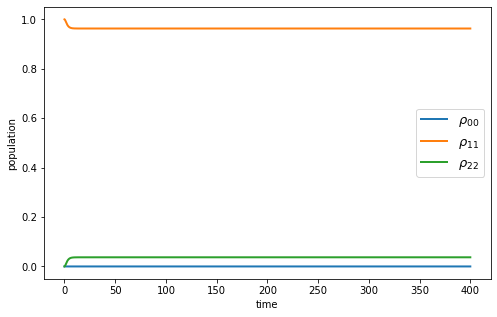

In [15]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, sol.y[0].real, label = r'$\rho_{00}$', lw = 2)
ax.plot(sol.t, sol.y[4].real, label = r'$\rho_{11}$', lw = 2)
ax.plot(sol.t, sol.y[8].real, label = r'$\rho_{22}$', lw = 2)
ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

In [16]:
results = {}
for Ωi in tqdm(np.linspace(0,1,5)):
    res = []
    for Δi in np.linspace(-7,7,101):
        replacements = [(Δμ, Δi),
                    (Δl, 0),
                    (Ωμ, Ωi),
                    (Ωl, 0.2),
                    (E3, 0),
                    (Γ21, 1)]
        sol = bloch.solveNumeric(replacements, [0,400], y0, method = 'BDF')
        res.append(np.trapz(sol.y[8].real, sol.t))
    results[Ωi] = res

  0%|                                                                                            | 0/5 [00:04<?, ?it/s]


KeyboardInterrupt: 

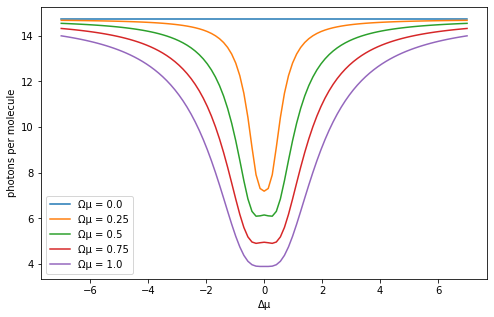

In [83]:
fig, ax = plt.subplots(figsize = (8,5))
for Ωi, res in results.items():
    ax.plot(np.linspace(-7,7,101), res, label = f'Ωμ = {Ωi}')
ax.set_xlabel('Δμ')
ax.set_ylabel('photons per molecule')
ax.legend()

In [88]:
results_Ω = []
for Ωi in tqdm(np.linspace(0,5,51)):
    replacements = [(Δμ, 0),
                (Δl, 0),
                (Ωμ, 0),
                (Ωl, Ωi),
                (E3, 0),
                (Γ21, 1)]
    sol = bloch.solveNumeric(replacements, [0,400], y0, method = 'BDF')
    results_Ω.append(np.trapz(sol.y[8].real, sol.t))

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:41<00:00,  1.23it/s]


Text(0, 0.5, 'photons per molecule')

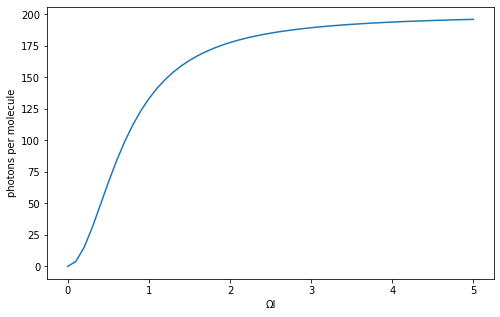

In [90]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(0,5,51), results_Ω)
ax.set_xlabel('Ωl')
ax.set_ylabel('photons per molecule')

In [23]:
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
E3 = Symbol(u'E3', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)
ωμ = Symbol(u'ωμ', real = True)
Ωμ = Symbol(u'Ωμ', real = True)

Δl = Symbol(u'Δl', real = True)
Δμ = Symbol(u'Δμ', real = True)

In [24]:
ham = Hamiltonian(7)
ham.addEnergies([E1, E1, E1, E2, E2, E2, E3])
ham.addCoupling(4,6,Ωl, ωl)
ham.addCoupling(1,4,Ωμ, ωμ)
ham.eqnTransform()
ham.defineZero(E2)
ham.defineStateDetuning(4,6,Δl)
ham.defineStateDetuning(1,4,Δμ)

In [25]:
Γ21 = Symbol(u'Γ21', real = True)
dis = Dissipator(7)
dis.addDecay(6,3,Γ21)
dis.addDecay(6,4,Γ21)
dis.addDecay(6,5,Γ21)

In [26]:
ham.hamiltonian

Matrix([
[E1,                      0,  0,  0,                      0,  0,                     0],
[ 0,                     E1,  0,  0,  -Ωμ*exp(1.0*I*t*ωμ)/2,  0,                     0],
[ 0,                      0, E1,  0,                      0,  0,                     0],
[ 0,                      0,  0, E2,                      0,  0,                     0],
[ 0, -Ωμ*exp(-1.0*I*t*ωμ)/2,  0,  0,                     E2,  0, -Ωl*exp(1.0*I*t*ωl)/2],
[ 0,                      0,  0,  0,                      0, E2,                     0],
[ 0,                      0,  0,  0, -Ωl*exp(-1.0*I*t*ωl)/2,  0,                    E3]])

In [27]:
ham.transformed

Matrix([
[E1,                        0,  0, 0,               0, 0,     0],
[ 0, 1.0*E3 - 1.0*Δl - 1.0*Δμ,  0, 0,           -Ωμ/2, 0,     0],
[ 0,                        0, E1, 0,               0, 0,     0],
[ 0,                        0,  0, 0,               0, 0,     0],
[ 0,                    -Ωμ/2,  0, 0, 1.0*E3 - 1.0*Δl, 0, -Ωl/2],
[ 0,                        0,  0, 0,               0, 0,     0],
[ 0,                        0,  0, 0,           -Ωl/2, 0,    E3]])

In [28]:
dis.dissipator

Matrix([
[                         0,                          0,                          0,                          0,                          0,                          0, -3*Γ21*ρ₀₆(t)/2],
[                         0,                          0,                          0,                          0,                          0,                          0, -3*Γ21*ρ₁₆(t)/2],
[                         0,                          0,                          0,                          0,                          0,                          0, -3*Γ21*ρ₂₆(t)/2],
[                         0,                          0,                          0,                 Γ21*ρ₆₆(t),                          0,                          0, -3*Γ21*ρ₃₆(t)/2],
[                         0,                          0,                          0,                          0,                 Γ21*ρ₆₆(t),                          0, -3*Γ21*ρ₄₆(t)/2],
[                         0,                          0,

In [29]:
bloch = BlochEquations(7, dis.density_matrix, ham.transformed, dis.dissipator)

In [30]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[3,3] = 1/3
y0[4,4] = 1/3
y0[5,5] = 1/3
y0 = y0.flatten()

In [31]:
replacements = [(Δμ, 0),
                (Δl, 0),
                (Ωμ, 0.2),
                (Ωl, 0.2),
                (E1, -10e3),
                (E3, 1e9),
                (Γ21, 1/3)]

In [32]:
%%time
sol = bloch.solveNumeric(replacements, [0,200], y0, method = 'BDF')

Wall time: 1.64 s


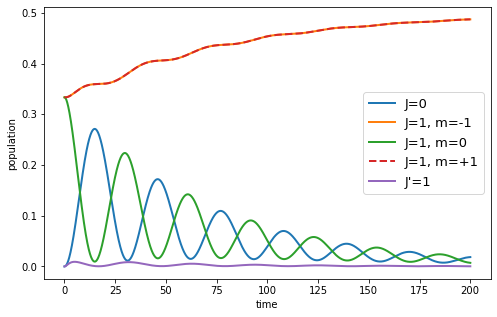

0.46117296412635955


In [33]:
r = np.einsum("iij->ij", sol.y.reshape(7,7,sol.t.size)).real
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, r[0:3].sum(axis = 0), label = r'J=0', lw = 2)
ax.plot(sol.t, r[3], label = r'J=1, m=-1', lw = 2)
ax.plot(sol.t, r[4], label = r'J=1, m=0', lw = 2)
ax.plot(sol.t, r[5], label = r'J=1, m=+1', lw = 2, ls = '--')
ax.plot(sol.t, r[6], label = r"J'=1", lw = 2)
ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

print(np.trapz(r[-1].real, sol.t))

In [159]:
results = {}
for Ωi in tqdm(np.linspace(0,1,5)):
    res = []
    for Δi in np.linspace(-7,7,101):
        replacements = [(Δμ, Δi),
                        (Δl, 0),
                        (Ωμ, Ωi),
                        (Ωl, 0.2),
                        (E1, -10e3),
                        (E3, 1e9),
                        (Γ21, 1/3)]
        sol = bloch.solveNumeric(replacements, [0,200], y0, method = 'BDF')
        res.append(np.trapz(sol.y[-1].real, sol.t))
    results[Ωi] = res

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [12:27<00:00, 149.43s/it]


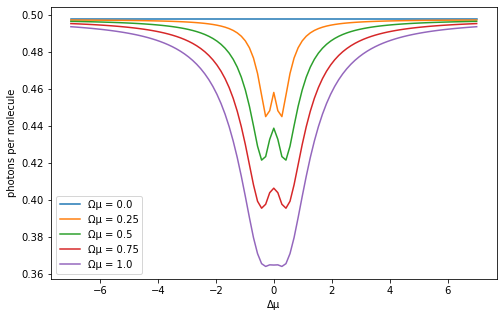

In [160]:
fig, ax = plt.subplots(figsize = (8,5))
for Ωi, res in results.items():
    ax.plot(np.linspace(-7,7,101), res, label = f'Ωμ = {Ωi}')
ax.set_xlabel('Δμ')
ax.set_ylabel('photons per molecule')
ax.legend()

In [15]:
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
E3 = Symbol(u'E3', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)

Δl = Symbol(u'Δl', real = True)

In [16]:
ham = Hamiltonian(3)
ham.addEnergies([E1, E2, E3])
ham.addCoupling(0,2,Ωl, ωl)
ham.addCoupling(1,2,Ωl, ωl)
ham.eqnTransform()
ham.defineZero(E2)
ham.defineStateDetuning(0,2,Δl)
ham.defineStateDetuning(1,2,Δl)

In [17]:
Γ21 = Symbol(u'Γ21', real = True)
dis = Dissipator(3)
dis.addDecay(2,0,Γ21)
dis.addDecay(2,1,Γ21)

In [18]:
ham.hamiltonian

Matrix([
[                    E1,                      0, -Ωl*exp(1.0*I*t*ωl)/2],
[                     0,                     E2, -Ωl*exp(1.0*I*t*ωl)/2],
[-Ωl*exp(-1.0*I*t*ωl)/2, -Ωl*exp(-1.0*I*t*ωl)/2,                    E3]])

In [19]:
ham.transformed

Matrix([
[1.0*E3 - 1.0*Δl,                         0, -Ωl/2],
[              0, -1.0*E1 + 1.0*E3 - 1.0*Δl, -Ωl/2],
[          -Ωl/2,                     -Ωl/2,    E3]])

In [20]:
bloch = BlochEquations(3, dis.density_matrix, ham.transformed, dis.dissipator)

In [21]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[0,0] = 0
y0[1,1] = 1
y0 = y0.flatten()

In [22]:
replacements = [(Δl, 0),
                (Ωl, 0.2),
                (E1, -0.3),
                (E3, 1e9),
                (Γ21, 1/2)]

In [23]:
%%time
sol = bloch.solveNumeric(replacements, [0,200], y0, method = 'BDF')

Wall time: 655 ms


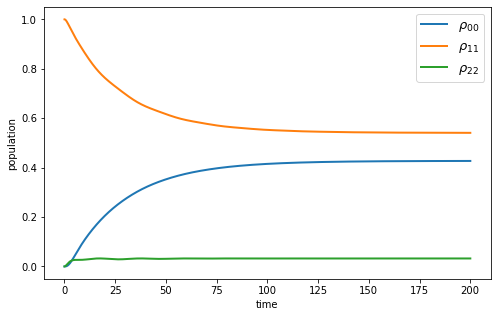

In [24]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, sol.y[0].real, label = r'$\rho_{00}$', lw = 2)
ax.plot(sol.t, sol.y[4].real, label = r'$\rho_{11}$', lw = 2)
ax.plot(sol.t, sol.y[8].real, label = r'$\rho_{22}$', lw = 2)
ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

In [25]:
replacements_generator = (((Δl, Δi),
                          (Ωl, Ωi),
                          (E1, -0.3),
                          (E3, 0),
                          (Γ21, 1/2)) for Ωi in np.linspace(0.2,1,5) for Δi in np.linspace(-1,1,101))

matrix_eq_generator = (bloch.generateSystem(replacements) for replacements in replacements_generator)

In [26]:
%%time
nprocs = 6
with multiprocessing.Pool(processes = nprocs) as pool:
    results = pool.starmap(multi_solve_ode_integrate_excited, ((matrix_eq, [0,400], y0, [8]) for matrix_eq in matrix_eq_generator))
results = np.array(results)

Wall time: 2min 19s


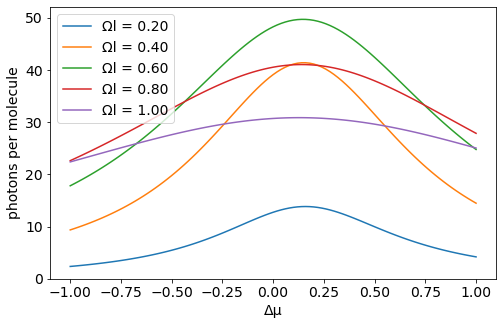

In [27]:
fig, ax = plt.subplots(figsize = (8,5))
for Ωi, res in zip(np.linspace(0.2,1,5), results.reshape(-1,101)):
    ax.plot(np.linspace(-1,1,101), res, label = f'Ωl = {Ωi:.2f}')
ax.set_xlabel('Δμ')
ax.set_ylabel('photons per molecule')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

In [28]:
for Ωi, res in zip(np.linspace(0.2,1,5), results.reshape(-1,101)):
    print(f"Ωl = {Ωi:.1f} -> {np.linspace(-1,1,101)[np.argmax(res)]:.2f}")

Ωl = 0.2 -> 0.16
Ωl = 0.4 -> 0.16
Ωl = 0.6 -> 0.14
Ωl = 0.8 -> 0.14
Ωl = 1.0 -> 0.12


In [29]:
replacements_generator = (((Δl, 0),
                          (Ωl, Ωi),
                          (E1, -0.3),
                          (E3, 0),
                          (Γ21, 1/2)) for Ωi in np.linspace(0,5,201))

matrix_eq_generator = (bloch.generateSystem(replacements) for replacements in replacements_generator)

In [30]:
%%time
nprocs = 6
with multiprocessing.Pool(processes = nprocs) as pool:
    results = pool.starmap(multi_solve_ode_integrate_excited, ((matrix_eq, [0,200], y0, [8]) for matrix_eq in matrix_eq_generator))

Wall time: 46.3 s


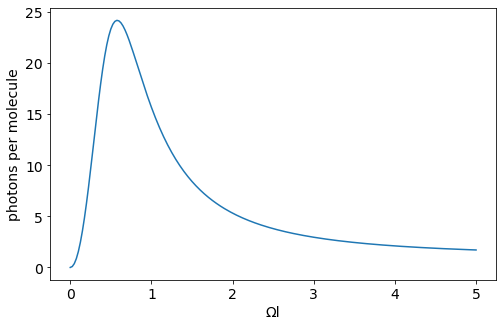

In [31]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(0,5,201), results)
ax.set_xlabel('Ωl')
ax.set_ylabel('photons per molecule')
set_fontsize(ax, 14)

In [32]:
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
E3 = Symbol(u'E3', real = True)
E4 = Symbol(u'E4', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)

Δl = Symbol(u'Δl', real = True)

In [33]:
ham = Hamiltonian(4)
ham.addEnergies([E1, E2, E3, E4])
ham.addCoupling(0,3,Ωl, ωl)
ham.addCoupling(1,3,Ωl, ωl)
ham.addCoupling(2,3,Ωl, ωl)

ham.eqnTransform()
ham.defineZero(E2)
ham.defineStateDetuning(0,3,Δl)
ham.defineStateDetuning(1,3,Δl)
ham.defineStateDetuning(2,3,Δl)

In [34]:
Γ21 = Symbol(u'Γ21', real = True)
dis = Dissipator(4)
dis.addDecay(3,0,Γ21)
dis.addDecay(3,1,Γ21)
dis.addDecay(3,2,Γ21)

In [35]:
ham.hamiltonian

Matrix([
[                    E1,                      0,                      0, -Ωl*exp(1.0*I*t*ωl)/2],
[                     0,                     E2,                      0, -Ωl*exp(1.0*I*t*ωl)/2],
[                     0,                      0,                     E3, -Ωl*exp(1.0*I*t*ωl)/2],
[-Ωl*exp(-1.0*I*t*ωl)/2, -Ωl*exp(-1.0*I*t*ωl)/2, -Ωl*exp(-1.0*I*t*ωl)/2,                    E4]])

In [36]:
ham.transformed

Matrix([
[1.0*E4 - 1.0*Δl,                         0,                              0, -Ωl/2],
[              0, -1.0*E1 + 1.0*E4 - 1.0*Δl,                              0, -Ωl/2],
[              0,                         0, -1.0*E1 + E3 + 1.0*E4 - 1.0*Δl, -Ωl/2],
[          -Ωl/2,                     -Ωl/2,                          -Ωl/2,    E4]])

In [37]:
bloch = BlochEquations(4, dis.density_matrix, ham.transformed, dis.dissipator)

In [38]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[1,1] = 1
y0 = y0.flatten()

In [39]:
replacements = [(Δl, 0),
                (Ωl, 0.2),
                (E1, -0.3),
                (E3, 0.2),
                (E4, 1e9),
                (Γ21, 1/3)]

In [40]:
%%time
sol = bloch.solveNumeric(replacements, [0,200], y0, method = 'BDF')

Wall time: 696 ms


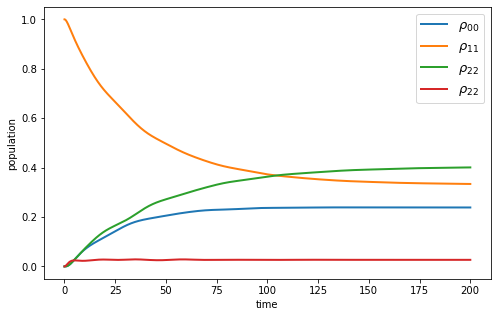

In [41]:
r = np.einsum("iij->ij", sol.y.reshape(4,4,sol.t.size)).real

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, r[0], label = r'$\rho_{00}$', lw = 2)
ax.plot(sol.t, r[1], label = r'$\rho_{11}$', lw = 2)
ax.plot(sol.t, r[2], label = r'$\rho_{22}$', lw = 2)
ax.plot(sol.t, r[3], label = r'$\rho_{22}$', lw = 2)

ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')
plt.show()

set_fontsize(ax, 14)

In [49]:
replacements_generator = (((Δl, 0),
                        (Ωl, Ωi),
                        (E1, -0.3),
                        (E3, 0.2),
                        (E4, 1e9),
                        (Γ21, 1/3)) for Ωi in np.linspace(0,5,201))

matrix_eq_generator = (bloch.generateSystem(replacements) for replacements in replacements_generator)

In [50]:
%%time
nprocs = 6
with multiprocessing.Pool(processes = nprocs) as pool:
    results = pool.starmap(multi_solve_ode_integrate_excited, ((matrix_eq, [0,400], y0, [-1]) 
                                                               for matrix_eq in matrix_eq_generator))

Wall time: 1min 31s


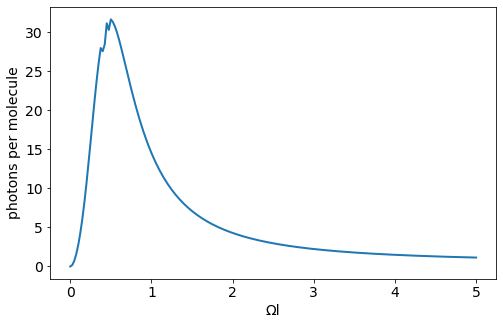

In [53]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.linspace(0,5,201), results, lw = 2)
ax.set_xlabel('Ωl')
ax.set_ylabel('photons per molecule')
set_fontsize(ax, 14)

In [54]:
replacements_generator = (((Δl, Δi),
                          (Ωl, Ωi),
                          (E1, -0.3),
                          (E3, 0.2),
                          (E4, 1e9),
                          (Γ21, 1/3)) for Ωi in np.linspace(0.2,1,5) for Δi in np.linspace(-1,1,101))

matrix_eq_generator = (bloch.generateSystem(replacements) for replacements in replacements_generator)

### For some reason the multiprocessing here never exits, even after finishing ODE solving on all cores

In [ ]:
%%time
nprocs = 6
with multiprocessing.Pool(processes = nprocs) as pool:
    results = pool.starmap(multi_solve_ode_integrate_excited, ((matrix_eq, [0,400], y0, [-1]) 
                                                               for matrix_eq in matrix_eq_generator))

In [ ]:
results = np.array(results)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
for Ωi, res in zip(np.linspace(0.2,1,5), results.reshape(-1,101)):
    ax.plot(np.linspace(-1,1,101), res, label = f'Ωl = {Ωi:.2f}')
ax.set_xlabel('Δμ')
ax.set_ylabel('photons per molecule')
ax.legend(fontsize = 14)

set_fontsize(ax, 14)

In [ ]:
for Ωi, res in zip(np.linspace(0.2,1,5), results.reshape(-1,101)):
    print(f"Ωl = {Ωi:.1f} -> {np.linspace(-1,1,101)[np.argmax(res)]:.2f}")

## Approximation of J=0, J=1, J'=1 system

In [57]:
E0 = Symbol(u'E0', real = True)
E1 = Symbol(u'E1', real = True)
E2 = Symbol(u'E2', real = True)
Ee = Symbol(u'Ee', real = True)

ωl = Symbol(u'ωl', real = True)
Ωl = Symbol(u'Ωl', real = True)
ωμ = Symbol(u'ωμ', real = True)
Ωμ = Symbol(u'Ωμ', real = True)

Δl = Symbol(u'Δl', real = True)
Δμ = Symbol(u'Δμ', real = True)

a = Symbol('a', real = True)
b = Symbol('b', real = True)
α = Symbol('α', real = True)
β = Symbol('β', real = True)

Δ = Symbol('Δ', real = True)

In [58]:
ham = Hamiltonian(4)
ham.addEnergies([E0, E1, E2, Ee])
ham.addCoupling(1,3,a*Ωl, ωl)
ham.addCoupling(2,3,b*Ωl, ωl)
ham.addCoupling(0,1,α*Ωμ, ωμ)
ham.addCoupling(0,2,β*Ωμ, ωμ)
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineStateDetuning(1,3,Δl)
ham.defineStateDetuning(2,3,Δl)
ham.defineStateDetuning(0,1,Δμ)

In [59]:
Γ21 = Symbol(u'Γ21', real = True)
dis = Dissipator(4)
dis.addDecay(3,1,Γ21/2)
dis.addDecay(3,2,Γ21/2)

In [60]:
ham.hamiltonian

Matrix([
[                      E0,  -Ωμ*α*exp(1.0*I*t*ωμ)/2,  -Ωμ*β*exp(1.0*I*t*ωμ)/2,                       0],
[-Ωμ*α*exp(-1.0*I*t*ωμ)/2,                       E1,                        0, -a*Ωl*exp(1.0*I*t*ωl)/2],
[-Ωμ*β*exp(-1.0*I*t*ωμ)/2,                        0,                       E2, -b*Ωl*exp(1.0*I*t*ωl)/2],
[                       0, -a*Ωl*exp(-1.0*I*t*ωl)/2, -b*Ωl*exp(-1.0*I*t*ωl)/2,                      Ee]])

In [61]:
from sympy import nsimplify

In [62]:
ham.transformed = nsimplify(ham.transformed)
ham.transformed = ham.transformed.subs(-E1+E2, Symbol('Δ', real = True))
ham.transformed

Matrix([
[-Δl - Δμ, -Ωμ*α/2, -Ωμ*β/2,       0],
[ -Ωμ*α/2,     -Δl,       0, -a*Ωl/2],
[ -Ωμ*β/2,       0,  Δ - Δl, -b*Ωl/2],
[       0, -a*Ωl/2, -b*Ωl/2,       0]])

In [63]:
bloch = BlochEquations(4, dis.density_matrix, ham.transformed, dis.dissipator)

In [64]:
y0 = np.zeros([bloch.levels, bloch.levels], dtype = complex)
y0[1,1] = 1/2
y0[2,2] = 1/2
y0 = y0.flatten()

In [65]:
Γ21_val = 1
replacements = [(Δl, 0),
                (Δμ, 0),
                (a, 1),
                (b, 1),
                (α, 1/3),
                (β, 2/3),
                (Ωl, 0.2*Γ21_val),
                (Ωμ, 0.2*Γ21_val),
                (Δ, 0*Γ21_val),
                (Γ21, Γ21_val)]

In [66]:
%%time
sol = bloch.solveNumeric(replacements, [0,300], y0, method = 'BDF')

Wall time: 988 ms


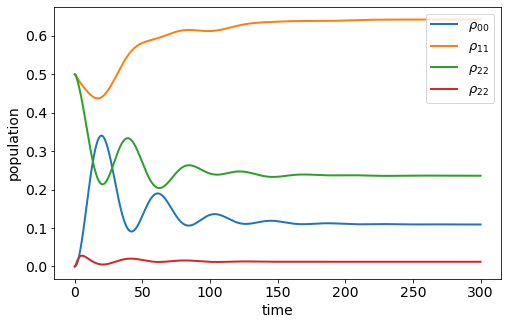

In [67]:
r = np.einsum("iij->ij", sol.y.reshape(4,4,sol.t.size)).real

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(sol.t, r[0], label = r'$\rho_{00}$', lw = 2)
ax.plot(sol.t, r[1], label = r'$\rho_{11}$', lw = 2)
ax.plot(sol.t, r[2], label = r'$\rho_{22}$', lw = 2)
ax.plot(sol.t, r[3], label = r'$\rho_{22}$', lw = 2)

ax.legend(fontsize = 13)
ax.set_xlabel('time')
ax.set_ylabel('population')

set_fontsize(ax, 14)

In [ ]:
replacements_generator = (((Δl, 0),
                        (Δμ, 0),
                        (a, 1),
                        (b, 1),
                        (α, 1/3),
                        (β, 2/3),
                        (Ωl, Ωli),
                        (Ωμ, Ωμi),
                        (Δ, 0*Γ21_val),
                        (Γ21, Γ21_val)) for Ωμi in np.linspace(0,4,21) for Ωli in np.linspace(0,4,21))

matrix_eq_generator = (bloch.generateSystem(replacements) for replacements in replacements_generator)

In [127]:
%%time
nprocs = 6
with multiprocessing.Pool(processes = nprocs) as pool:
    results = pool.starmap(multi_solve_ode_integrate_excited, ((matrix_eq, [0,300], y0, [-1]) 
                                                               for matrix_eq in matrix_eq_generator))
results = np.array(results)

Wall time: 4min 13s


In [128]:
X, Y = np.meshgrid(np.linspace(0,4,21), np.linspace(0,4,21))

<ipython-input-130-7d6791b45582>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, results.reshape(-1,21))


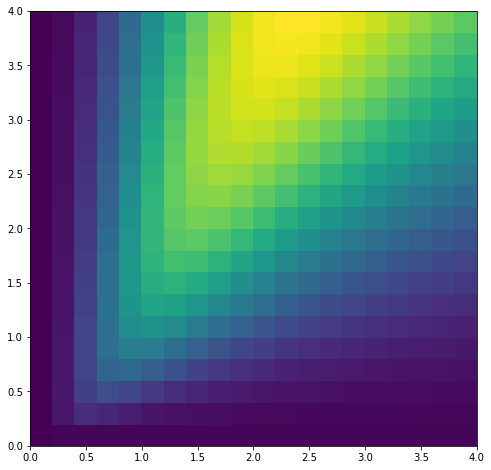

In [130]:
fig, ax = plt.subplots(figsize = (8,8))

ax.pcolormesh(X, Y, results.reshape(-1,21), shading = 'auto')

In [150]:
replacements_generator = (((Δl, 0),
                        (Δμ, 0),
                        (a, 1),
                        (b, 1),
                        (α, 1/3),
                        (β, 2/3),
                        (Ωl, Ωli),
                        (Ωμ, Ωμi),
                        (Δ, 4*Γ21_val),
                        (Γ21, Γ21_val)) for Ωμi in np.linspace(0,20,41) for Ωli in np.linspace(0,20,41))

matrix_eq_generator = (bloch.generateSystem(replacements) for replacements in replacements_generator)

In [151]:
%%time
nprocs = 6
with multiprocessing.Pool(processes = nprocs) as pool:
    results = pool.starmap(multi_solve_ode_integrate_excited, ((matrix_eq, [0,300], y0, [-1]) 
                                                               for matrix_eq in matrix_eq_generator))
results = np.array(results)

Wall time: 20min 13s


In [154]:
X, Y = np.meshgrid(np.linspace(0,20,41), np.linspace(0,20,41))

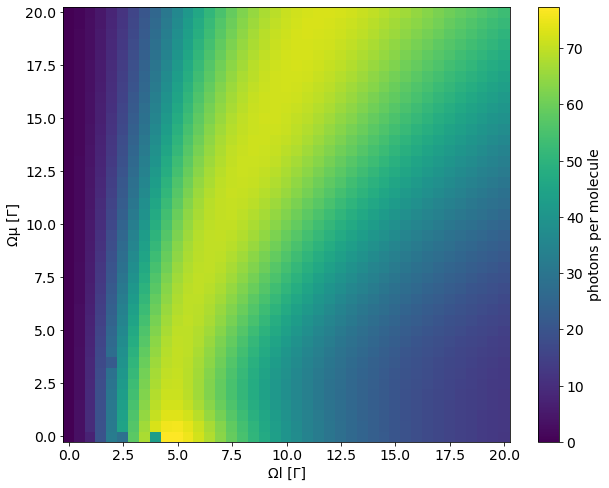

In [177]:
fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X, Y, results.reshape(-1,41), shading="auto")
cbar = fig.colorbar(c)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

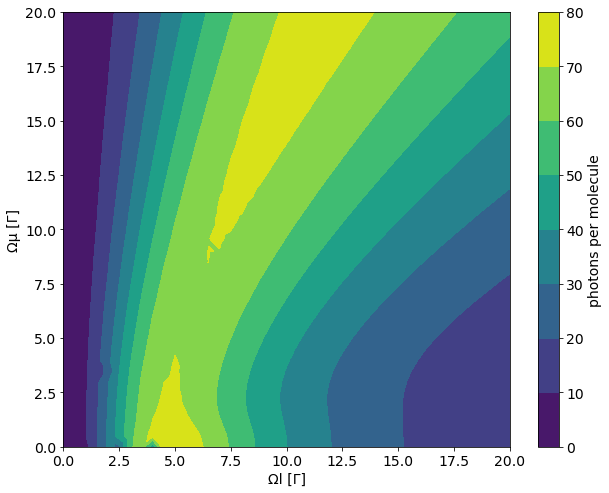

In [178]:
x,y = zip(*[(Ωli, Ωμi) for Ωμi in np.linspace(0,20,41) for Ωli in np.linspace(0,20,41)])

fig, ax = plt.subplots(figsize = (10,8))

c = ax.tricontourf(x,y,results)
cbar = fig.colorbar(c)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [49]:
replacements_generator = (((Δl, 0),
                        (Δμ, 0),
                        (a, 1),
                        (b, 1),
                        (α, 1/3),
                        (β, 2/3),
                        (Ωl, Ωli),
                        (Ωμ, Ωμi),
                        (Δ, 0.2*Γ21_val),
                        (Γ21, Γ21_val)) for Ωμi in np.linspace(0,20,41) for Ωli in np.linspace(0,20,41))

matrix_eq_generator = (bloch.generateSystem(replacements) for replacements in replacements_generator)

In [50]:
%%time
nprocs = 6
with multiprocessing.Pool(processes = nprocs) as pool:
    results = pool.starmap(multi_solve_ode_integrate_excited, ((matrix_eq, [0,300], y0, [-1]) 
                                                               for matrix_eq in matrix_eq_generator))
results = np.array(results)

Wall time: 21min 21s


In [51]:
nsteps = int(np.sqrt(results.size))
X, Y = np.meshgrid(np.linspace(0,20,nsteps), np.linspace(0,20,nsteps))

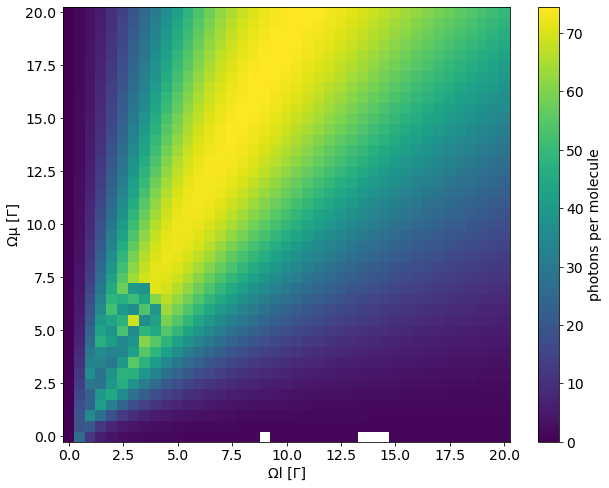

In [52]:
fig, ax = plt.subplots(figsize = (10,8))

c = ax.pcolormesh(X, Y, results.reshape(-1,nsteps), shading="auto")
cbar = fig.colorbar(c)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

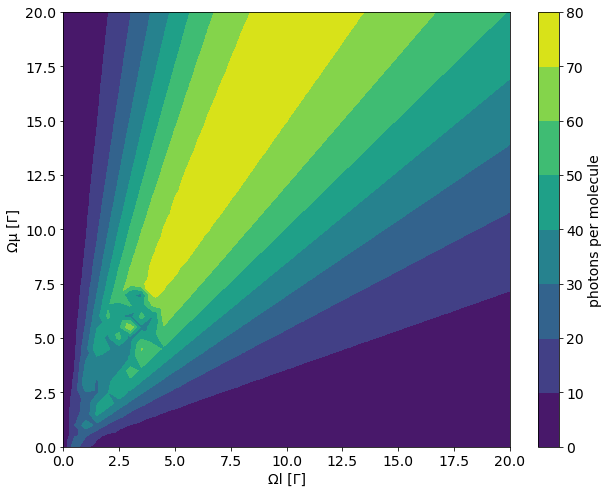

In [53]:
x,y = zip(*[(Ωli, Ωμi) for Ωμi in np.linspace(0,20,nsteps) for Ωli in np.linspace(0,20,nsteps)])
x = np.asarray(x)
y = np.asarray(y)

m = ~np.isnan(results)

fig, ax = plt.subplots(figsize = (10,8))

c = ax.tricontourf(x[m],y[m],results[m])
cbar = fig.colorbar(c)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel('Ωμ [Γ]')
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [195]:
levels = 4
from sympy import Function, conjugate, linear_eq_to_matrix

eqns_rhs = bloch.equations.rhs

t = Symbol('t', real = True)
for i in range(levels):
    for j in range(i,levels):
        tmp = Function(u'\u03C1{0}{1}'.format(chr(0x2080+i), 
                                                    chr(0x2080+j)))
        tmp1 = Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+j), 
                                                    chr(0x2080+i)))
        eqns_rhs = eqns_rhs.subs(conjugate(tmp(t)), tmp1)

for i in range(levels):
    for j in range(i,levels):
        tmp = Function(u'\u03C1{0}{1}'.format(chr(0x2080+i), 
                                                    chr(0x2080+j)))
        tmp1 = Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+i), 
                                                    chr(0x2080+j)))
        eqns_rhs = eqns_rhs.subs(tmp(t), tmp1)

syms = []
for i in range(levels):
    for j in range(levels):
        syms.append(Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+i), 
                                                        chr(0x2080+j))))
        
eqns_rhs = eqns_rhs.subs(replacements)

In [160]:
from julia import Main

In [347]:
Main.eval("""
using BenchmarkTools
addprocs(6)

@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    include("../utils/general_ode_functions.jl")
end
""")

In [350]:
Main.eval("""
@everywhere begin
    @variables Δl, Δμ, Ωμ, Ωl, a, b, α, β, Δ, Γ21
    @variables ρ[1:4,1:4]

    hamiltonian  = [-Δl-Δμ -α*Ωμ/2 -β*Ωμ/2 0
                           -α*Ωμ/2 -Δl 0 -a*Ωl/2
                          -β*Ωμ/2 0 Δ-Δl -b*Ωl/2
                          0 -a*Ωl/2 -b*Ωl/2 0]

    dissipator = [0 0 0 -Γ21/2*ρ[1,4]
                  0 Γ21/2*ρ[4,4] 0 -Γ21/2*ρ[2,4]
                  0 0 Γ21/2*ρ[4,4] -Γ21/2*ρ[3,4]
                  -Γ21/2*ρ[4,1] -Γ21/2*ρ[4,2] -Γ21/2*ρ[4,3] -Γ21*ρ[4,4]]
    tmp = 0
end
""");

In [351]:
Main.eval("""
@everywhere begin
    ham_expr = build_function(hamiltonian, Δl, Δμ, Ωμ, Ωl, a, b, α, β, Δ)
    ham = eval(ham_expr[1])

    dis_expr = build_function(dissipator, Γ21, ρ)
    dis = eval(dis_expr[1])

    tmp = 0
end
""");

In [352]:
Main.u0 = y0.reshape(-1,4)
Main.eval("""
p = [0,0,0.2,0.2,1,1,1/3,2/3,0,1]
""");

In [353]:
Main.eval("""
@everywhere function rhs(u, p, t)
    h = ham(p[1:end-1]...)
    -1im*(h*u - u*h) + dis(p[end], u)
end
""");

In [354]:
Main.eval("""
tspan = (0.0, 300.)
prob = ODEProblem(rhs, u0, tspan, p)
""");

In [355]:
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-10, reltol = 1e-10)
""");

In [356]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((Main.u0.shape[0], Main.u0.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t") 

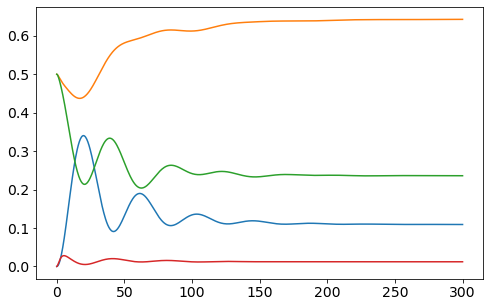

In [357]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(t_array, pop_results.T)

set_fontsize(ax, 14)

In [358]:
from sympy import Function, conjugate
levels = 4

eqns_rhs = bloch.equations.rhs.subs(replacements)

t = Symbol('t', real = True)
for i in range(levels):
    for j in range(i,levels):
        tmp = Function(u'\u03C1{0}{1}'.format(chr(0x2080+i), 
                                                    chr(0x2080+j)))
        tmp1 = Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+j), 
                                                    chr(0x2080+i)))
        eqns_rhs = eqns_rhs.subs(conjugate(tmp(t)), tmp1)

for i in range(levels):
    for j in range(i,levels):
        tmp = Function(u'\u03C1{0}{1}'.format(chr(0x2080+i), 
                                                    chr(0x2080+j)))
        tmp1 = Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+i), 
                                                    chr(0x2080+j)))
        eqns_rhs = eqns_rhs.subs(tmp(t), tmp1)

syms = []
for i in range(levels):
    for j in range(levels):
        syms.append(Symbol(u'\u03C1{0}{1}'.format(chr(0x2080+i), 
                                                        chr(0x2080+j))))

In [359]:
matrix_eq = np.array(linear_eq_to_matrix(eqns_rhs, syms)[0]).astype(complex)

In [360]:
y = y0.copy()
Main.eval("u = copy(u0)")

for _ in range(10):
    Main.eval("u = rhs(u, p, 0)")
    y = matrix_eq@y
    print(np.isclose(y.reshape(-1,4),Main.u))

[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]
[[ True  True  True

In [361]:
replacements_generator = (((Δl, 0),
                        (Δμ, 0),
                        (a, 1),
                        (b, 1),
                        (α, 1/3),
                        (β, 2/3),
                        (Ωl, Ωli),
                        (Ωμ, Ωμi),
                        (Δ, 4*Γ21_val),
                        (Γ21, Γ21_val)) for Ωμi in np.linspace(0,20,41) for Ωli in np.linspace(0,20,41))

matrix_eq_generator = (bloch.generateSystem(replacements) for replacements in replacements_generator)

In [370]:
Ωls = np.linspace(0,20,81)
Ωμs = np.linspace(0,20,81)
params = np.array(np.meshgrid(Ωls, Ωμs)).T.reshape(-1,2)
Main.params = params
Main.eval("@everywhere params = $params")

In [371]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [0,0,params[i,2],params[i,1],1,1,1/3,2/3,4,1])
end
""")

In [372]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[end])) for j in 1:size(sol.u)[1]]), false
end""")

In [373]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [374]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

297.1150517

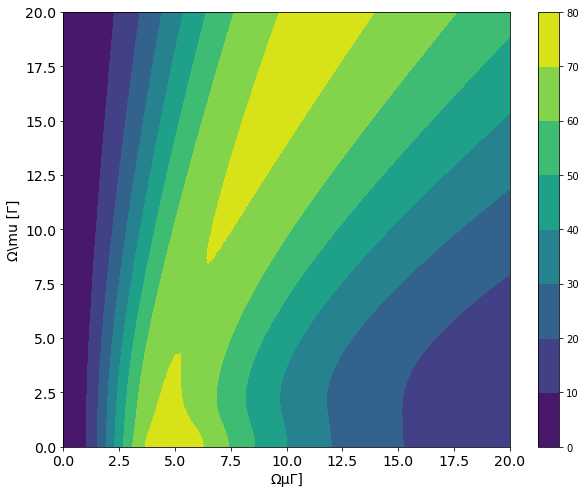

In [376]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")))

fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')

set_fontsize(ax, 14)

In [377]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [0,0,params[i,2],params[i,1],1,1,1/3,2/3,0.2,1])
end
""")

In [378]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[end])) for j in 1:size(sol.u)[1]]), false
end""")

In [379]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [380]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

294.5006302

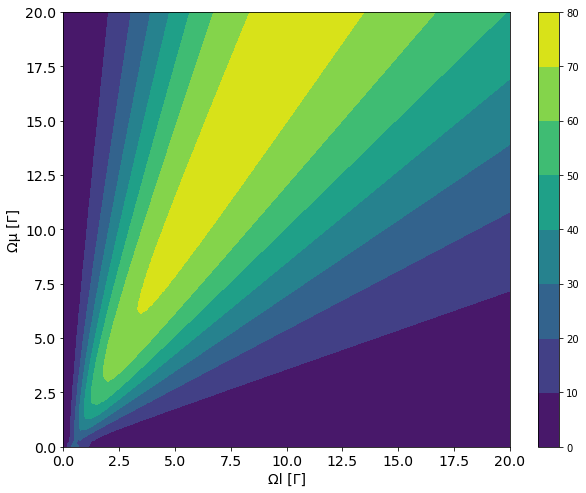

In [383]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")))

fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')

set_fontsize(ax, 14)

In [384]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [0,0,params[i,2],params[i,1],1,1,1/3,2/3,0,1])
end
""")

In [385]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[end])) for j in 1:size(sol.u)[1]]), false
end""")

In [386]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [387]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

330.2327606

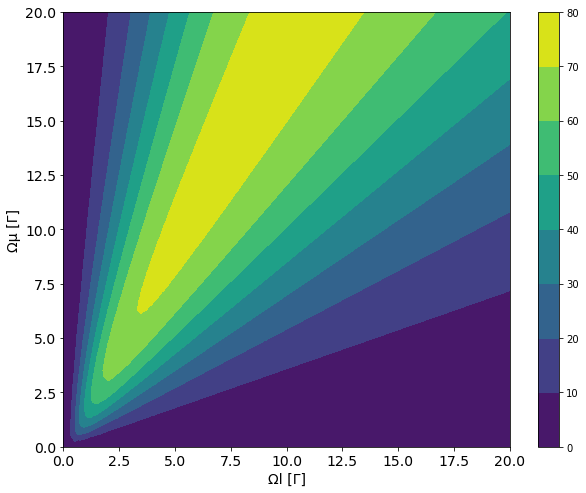

In [388]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")))

fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')

set_fontsize(ax, 14)

In [389]:
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob, p = [0,0.3,params[i,2],params[i,1],1,1,1/3,2/3,0,1])
end
""")

In [390]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[end])) for j in 1:size(sol.u)[1]]), false
end""")

In [391]:
Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");

In [392]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 1e-9, reltol = 1e-6)
sim.elapsedTime
""")

310.8254171

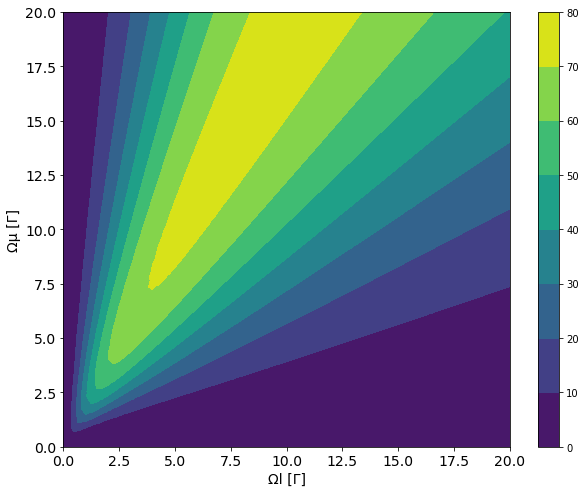

In [393]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0], params[:,1], np.array(Main.eval("sim.u")))

fig.colorbar(tcf)

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'Ωμ [Γ]')

set_fontsize(ax, 14)